In [140]:
import asmsa
import mdtraj as md
import nglview as nv
import numpy as np
from tensorflow.keras.saving import load_model
import torch
import gromacs as gmx
from gromacs import formats as gmf
import os
import matplotlib.pyplot as plt

In [ ]:
os.environ['REQUEST_CPU'] = '8'
os.environ['REQUEST_RAM'] = '32'

In [ ]:
"""conf = "trpcage_correct.pdb"
topol = "topol_correct.top"
index = 'index_correct.ndx'
gro = 'trpcage_correct.gro' """
exec(open('inputs.py').read())

In [ ]:
# outputs of prepare.ipynb

#train_tr = md.load('x_train.xtc',top=conf)
#test_tr = md.load('x_test.xtc',top=conf)

train_tr = md.load('train.xtc',top=conf)
test_tr = md.load('test.xtc',top=conf)

In [ ]:
train_g = np.moveaxis(train_tr.xyz,0,-1)
test_g = np.moveaxis(test_tr.xyz,0,-1)

In [ ]:
train_g.shape

In [ ]:
sparse_dists = asmsa.NBDistancesSparse(train_g.shape[0], density=2)
mol = asmsa.Molecule(pdb=conf,top=topol,ndx=index,fms=[sparse_dists])

In [ ]:
mol.model.dihed4_model.forward(torch.tensor(test_g)).shape

In [ ]:
train_int = mol.intcoord(train_g)
train_int.shape

In [ ]:
test_int = mol.intcoord(test_g)
test_int.shape

In [ ]:
topol

In [ ]:
mol.dihed4

In [ ]:
mol.dihed9

In [183]:
latent = np.loadtxt('sample_latent.txt')
decout = np.loadtxt('sample_int.txt')

In [184]:
latent.shape

(2048, 2)

In [ ]:
train_mean = np.loadtxt('datasets/intcoords/mean.txt',dtype=np.float32)
train_scale = np.loadtxt('datasets/intcoords/scale.txt',dtype=np.float32)

In [185]:
decout_scaled = decout * train_scale + train_mean
decout_scaled.shape

(2048, 1355)

In [ ]:
# see train.ipynb
grotr = md.load(gro)
nhs = grotr.topology.select('element != H')

with open(index) as f:
    f.readline()
    ndx = np.fromstring(" ".join(f),dtype=np.int32,sep=' ')-1

pdb2gmx = nhs[np.argsort(ndx)]+1


In [ ]:
pdb2gmx

In [186]:
dihed9_gmx = [
    [ pdb2gmx[a] for a in d ]
    for d in mol.dihed9
]
dihed4_gmx = [
    [ pdb2gmx[a] for a in d ]
    for d in mol.dihed4
]

In [187]:
dihed9_gmx

[[1, 5, 13, 14],
 [1, 5, 13, 15],
 [1, 5, 7, 10],
 [5, 13, 15, 17],
 [5, 7, 10, 11],
 [5, 7, 10, 12],
 [13, 5, 7, 10],
 [13, 15, 17, 23],
 [13, 15, 17, 19],
 [14, 13, 15, 17],
 [7, 5, 13, 14],
 [7, 5, 13, 15],
 [15, 17, 23, 24],
 [15, 17, 23, 25],
 [17, 23, 25, 27],
 [23, 25, 27, 44],
 [23, 25, 27, 29],
 [24, 23, 25, 27],
 [19, 17, 23, 24],
 [19, 17, 23, 25],
 [25, 27, 44, 45],
 [25, 27, 44, 46],
 [25, 27, 29, 32],
 [27, 44, 46, 48],
 [27, 29, 32, 33],
 [27, 29, 32, 42],
 [44, 27, 29, 32],
 [44, 46, 48, 54],
 [44, 46, 48, 50],
 [45, 44, 46, 48],
 [29, 27, 44, 45],
 [29, 27, 44, 46],
 [29, 32, 33, 35],
 [29, 32, 42, 40],
 [32, 33, 35, 37],
 [33, 32, 42, 40],
 [33, 35, 37, 40],
 [33, 35, 37, 38],
 [42, 32, 33, 35],
 [35, 37, 40, 42],
 [37, 40, 42, 32],
 [38, 37, 40, 42],
 [46, 48, 54, 55],
 [46, 48, 54, 56],
 [48, 54, 56, 58],
 [54, 56, 58, 71],
 [54, 56, 58, 60],
 [55, 54, 56, 58],
 [50, 48, 54, 55],
 [50, 48, 54, 56],
 [56, 58, 71, 72],
 [56, 58, 71, 73],
 [56, 58, 60, 63],
 [58, 71, 7

In [ ]:
gmx.select(s=gro,on='bb.ndx',select='Backbone')

In [ ]:
with open('bb.ndx') as bb:
    bb.readline()
    l = " ".join(bb.readlines())
    bbndx = np.array(l.split(),np.int32)

In [188]:
dih9_ndx = [ np.where(np.all(dihed9_gmx == bbndx[i:i+4],axis=1))[0][0] for i in range(len(bbndx)-3) ]

# XXX: backbone dihedrals seem to be all in dih9 and none in dih4

In [189]:
len(dih9_ndx), bbndx.shape

(57, (60,))

In [190]:
off = mol.dihed4.shape[0]*2+mol.angles.shape[0]+mol.bonds.shape[0]
size = mol.dihed9.shape[0]

In [191]:
%cd ~/ASMSA

/home/jovyan/ASMSA


In [192]:

for out_idx in range(decout.shape[0]):
# for out_idx in range(3):
    dec_out = decout[out_idx,:]
    # dec_out.shape
    
    os.system(f'rm -rf min_{out_idx} && mkdir min_{out_idx}')
    os.chdir(f'min_{out_idx}')
    
    
    diff = train_int.T - dec_out
    msd = np.sum(diff * diff,axis=1)
    
    minidx = np.argmin(msd)
    
    mintr = train_tr[minidx]
    mintr.save('min.pdb')

    dec_dih9_sc = decout_scaled[out_idx][off:off+size*2]
    #dec_dih9_sc.shape
    
    dec_dih9 = np.arctan2(dec_dih9_sc[0:size],dec_dih9_sc[size:]) / np.pi * 180.
    
    bb_angles = [ dec_dih9[i] for i in dih9_ndx ]
    
    with open('dihre.itp','w') as p:
        p.write('[ dihedral_restraints ]\n')
        for i in range(0,len(bbndx)-3):
            p.write('  '.join(map(str,bbndx[i:i+4])))
            p.write(f' 1 {bb_angles[i]} 0 5000\n')

    os.chdir('..')


In [124]:
def onemin(out_idx):
    # dec_out = test_int[:,out_idx]
    dec_out = decout[out_idx,:]
    # dec_out.shape
    
    os.system(f'rm -rf min_{out_idx} && mkdir min_{out_idx}')
    os.chdir(f'min_{out_idx}')


    diff = train_int.T - dec_out
    msd = np.sum(diff * diff,axis=1)
    
    minidx = np.argmin(msd)
    
    mintr = train_tr[minidx]
    mintr.save('min.pdb')
    
    # nv.show_mdtraj(mintr)
    
    gmx.pdb2gmx(f='min.pdb',o='min.gro',p='min.top',water='tip3p',ff='amber94')
    
    mdbox=2.0
    gmx.editconf(f='min.gro',o="min-box.gro",c=True,d=str(mdbox),bt="dodecahedron")
    
    dec_dih9_sc = decout_scaled[out_idx][off:off+size*2]
    #dec_dih9_sc.shape
    
    dec_dih9 = np.arctan2(dec_dih9_sc[0:size],dec_dih9_sc[size:]) / np.pi * 180.
    
    bb_angles = [ dec_dih9[i] for i in dih9_ndx ]
    
    with open('posre.itp','w') as p:
        p.write('[ dihedral_restraints ]\n')
        for i in range(0,len(bbndx)-3):
            p.write('  '.join(map(str,bbndx[i:i+4])))
            p.write(f' 1 {bb_angles[i]} 0 5000\n')
    
    
    with open('min.mdp','w') as m:
        m.write('''
integrator  = steep         ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0        ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01          ; Minimization step size
nsteps      = 50000         ; Maximum number of (minimization) steps to perform

nstxout                 = 1         
nstvout                 = 0         
nstfout                 = 0         
nstlog                  = 5
nstxout-compressed      = 1

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
cutoff-scheme   = Verlet    ; Buffered neighbor searching
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
coulombtype     = Cut-off   ; Treatment of long range electrostatic interactions
rcoulomb        = 1.0       ; Short-range electrostatic cut-off
rvdw            = 1.0       ; Short-range Van der Waals cut-off
pbc             = xyz       ; Periodic Boundary Conditions in all 3 dimensions

disre           = Simple
define                  = -DPOSRES 
''')
            
    gmx.grompp(f='min.mdp',c='min-box.gro',p='min.top',o='min.tpr')
    
    res = gmx.mdrun(deffnm='min')
    os.chdir('..')
    return res

'''moved to run-min.sh to avoid kubectl exec overhead'''

from concurrent.futures import ProcessPoolExecutor
with ProcessPoolExecutor(max_workers=8) as executor:
    results = list(executor.map(onemin, range(latent.shape[0])))


In [129]:
len(results)

2048

In [ ]:
# run final-energies.sh directly in the gromacs container

In [137]:
def final_e(i):
    x = gmf.XVG(f'min_{i}/min.xvg')
    return x.array[1:,-1]

energ = np.array([ final_e(i) for i in range(latent.shape[0]) ])

In [138]:
gmx.tr

(2048, 2)

In [196]:
final_tr = md.load([ f'min_{i}/min.gro' for i in range(latent.shape[0]) ])

In [150]:
base_tr = md.load(gro)

In [197]:
final_tr.superpose(base_tr)

<mdtraj.Trajectory with 2048 frames, 272 atoms, 20 residues, and unitcells at 0x7f927462eb60>

In [198]:
rmsd = md.rmsd(final_tr,base_tr)

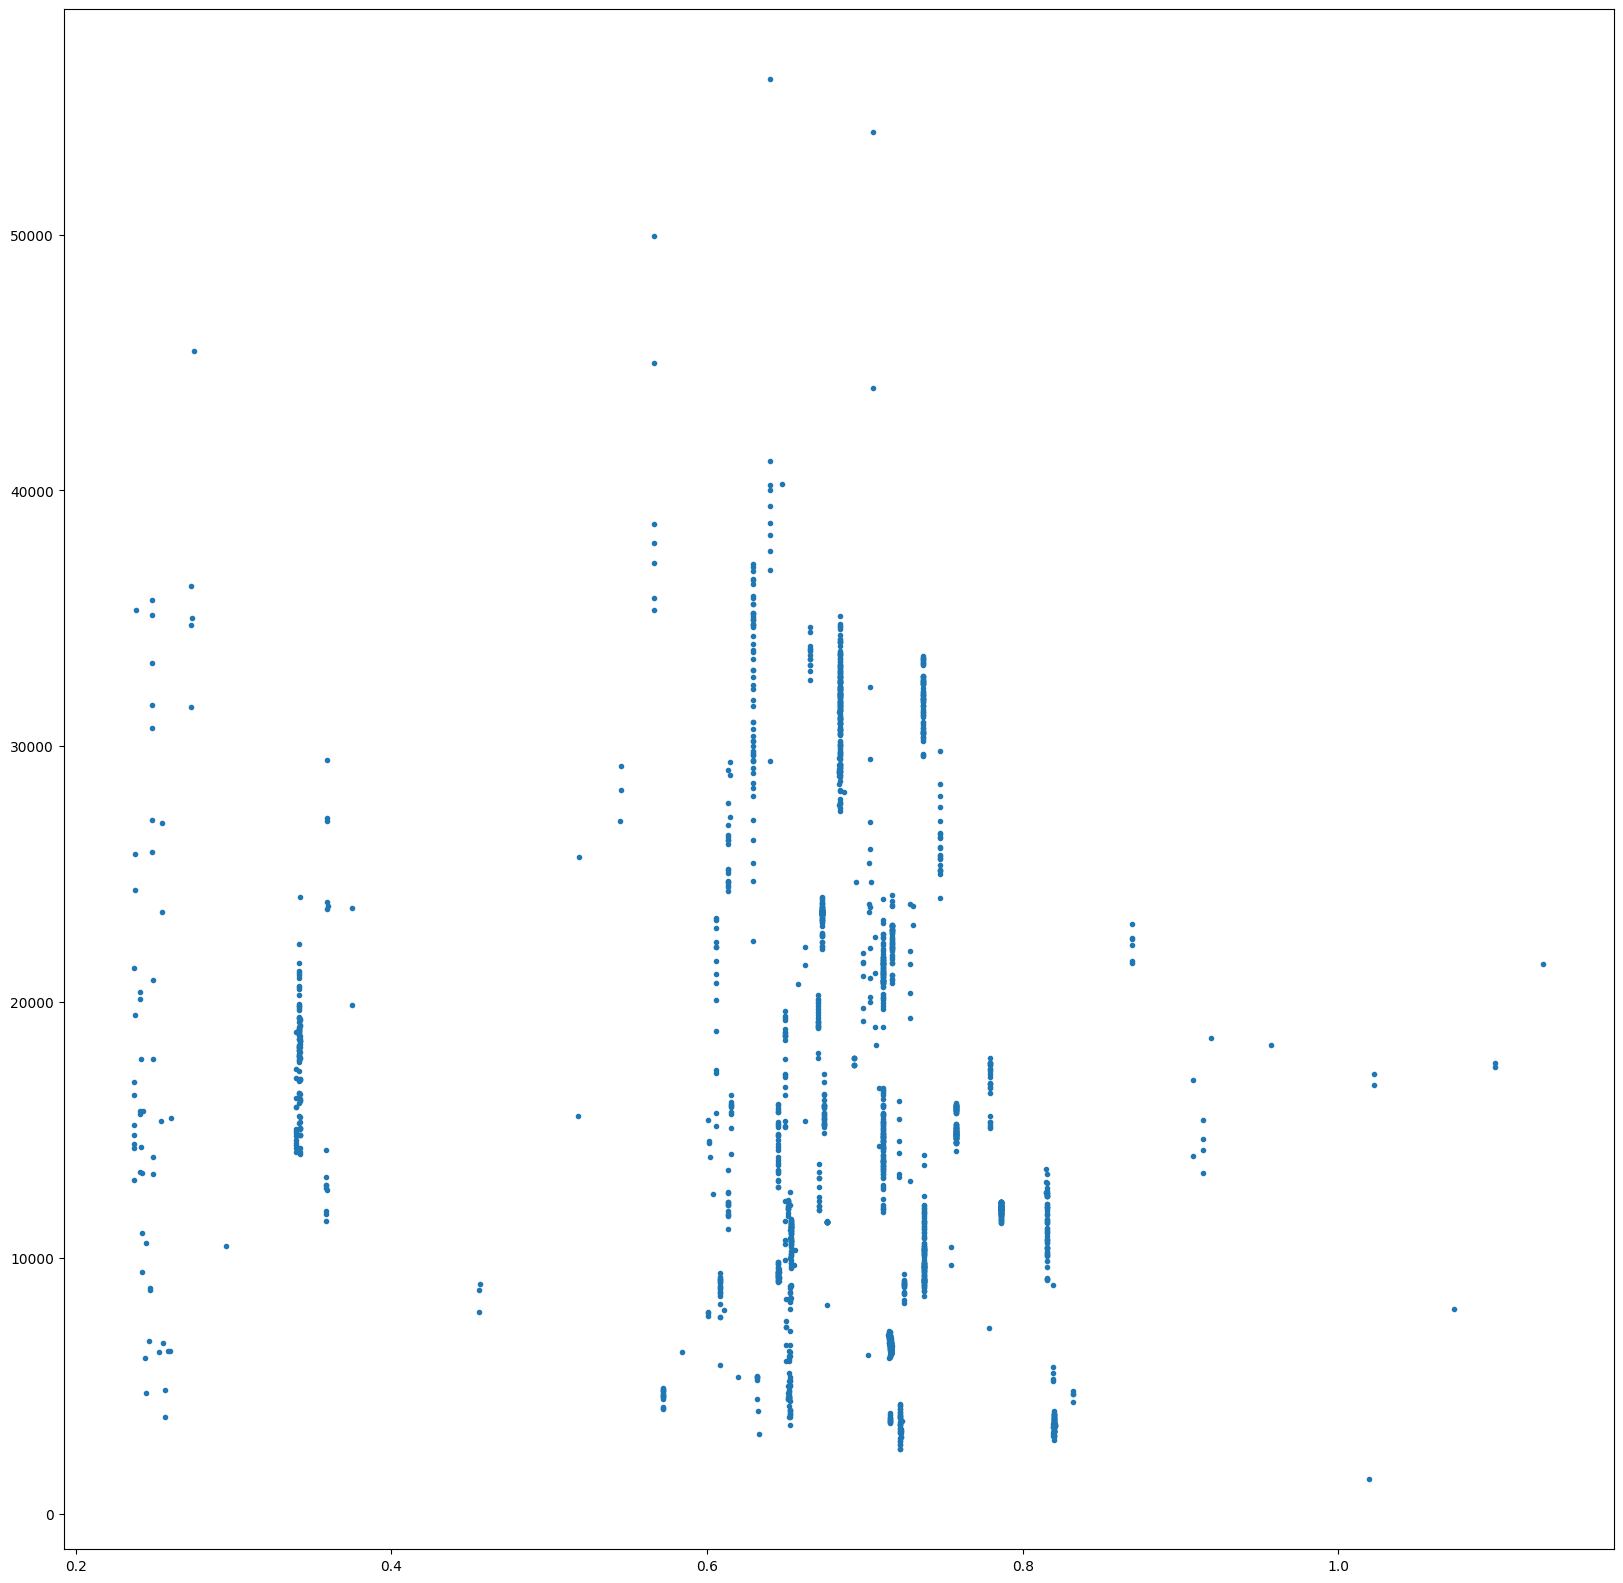

In [170]:
plt.figure(figsize=(20,20))
#plt.scatter(rmsd,energ[:,0]-energ[:,1],marker='.')
plt.scatter(rmsd,energ[:,1],marker='.')
plt.show()

In [153]:
energ.shape

(2048, 2)

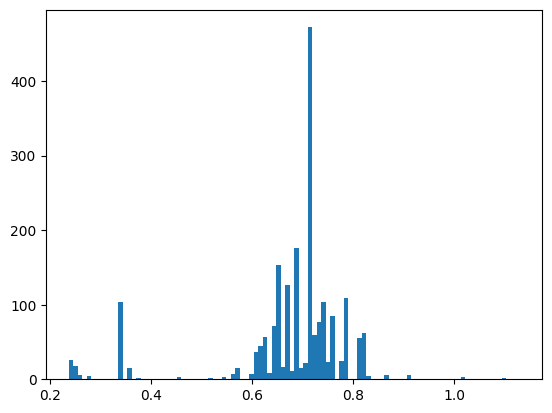

In [171]:
plt.hist(rmsd,bins=100)
plt.show()

In [173]:
base_tr.xyz.shape, final_tr.xyz.shape

((1, 272, 3), (2048, 272, 3))

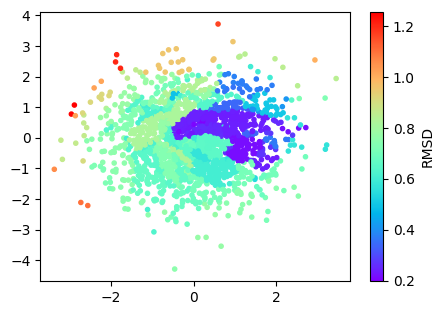

In [202]:
plt.figure(figsize=(5,3.5))
plt.scatter(latent[:,0],latent[:,1],marker='.',c=rmsd,cmap=plt.get_cmap('rainbow'))
plt.colorbar().set_label('RMSD')
plt.savefig('fig2.pdf')
plt.show()

In [ ]:
tr = md.load('min.trr',top='min-box.gro')[:100]
v=nv.show_mdtraj(tr)
#v.clear()
v.add_representation('licorice')
v

In [ ]:
nv.show_file('min-box.gro')

In [ ]:
!cp min.top restrained.top

off = mol.dihed4.shape[0]*2+mol.dihed9.shape[0]*2+mol.angles.shape[0]+mol.bonds.shape[0]

dec_dist = dec_out_scaled[off:]


with open('restrained.top','a') as t:
    t.write('''
[ distance_restraints ]
''')
    for i,d in enumerate(sparse_dists.bonds):
        t.write(f'{pdb2gmx[d[0]]} {pdb2gmx[d[1]]} 1 {i} 2 {dec_dist[i]*.99} {dec_dist[i]*1.01} 42.0 10.0\n')

In [ ]:
with open('min.mdp','w') as m:
    m.write('''
integrator  = steep         ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0        ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01          ; Minimization step size
nsteps      = 50000         ; Maximum number of (minimization) steps to perform

nstxout                 = 0         
nstvout                 = 0         
nstfout                 = 0         
nstlog                  = 5
nstxout-compressed      = 0

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
cutoff-scheme   = Verlet    ; Buffered neighbor searching
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
coulombtype     = Cut-off   ; Treatment of long range electrostatic interactions
rcoulomb        = 1.0       ; Short-range electrostatic cut-off
rvdw            = 1.0       ; Short-range Van der Waals cut-off
pbc             = xyz       ; Periodic Boundary Conditions in all 3 dimensions

disre           = Simple
''')

In [ ]:
gmx.grompp(f="min.mdp",c="min-box.gro",p='restrained.top',o="min.tpr")

In [ ]:
mdrun(deffnm="min")

In [ ]:
solm = md.load('min.gro')
nhs = solm.topology.select('element != H')
solm.atom_slice(nhs,inplace=True)
v = nv.show_mdtraj(solm)

refm = md.load_pdb(conf)
refm.xyz = train_g[:,:,minidx]
refm.superpose(solm)

v.add_component(refm)
v.clear(component=0)
v.clear(component=1)

v.add_representation('licorice',color='green',component=1)
v.add_representation('licorice',color='red',component=0)

v

In [ ]:
gmx.energy(f='min.edr',input=['Potential','Dis.-Rest.'],o='min.xvg')

In [ ]:
import matplotlib.pyplot as plt
energ = np.loadtxt('min.xvg',comments=['#','@'])
plt.plot(energ[:,1],label='Dis.-Rest.')
plt.plot(energ[:,2],label='Potential')
plt.plot(energ[:,2]-energ[:,1],label='Net')
plt.yscale('log')
plt.legend()
plt.show()
